# Pre-trained Model for Perturbation SEARCH

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
import matplotlib
from torch import nn
from torch.nn import functional as F
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from torch_geometric.loader import DataLoader
from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.model import TransformerGenerator
from scgpt.loss import (
    masked_mse_loss,
    criterion_neg_log_bernoulli,
    masked_relative_error,
)
from scgpt.tokenizer import tokenize_batch, pad_batch, tokenize_and_pad_batch
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

matplotlib.rcParams["savefig.transparent"] = True
warnings.filterwarnings("ignore")

set_seed(42)


/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## Training Settings

In [3]:
# settings for data prcocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
pad_value = 0  # for padding values
pert_pad_id = 0
include_zero_gene = "all"
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
amp = True
load_model = "../save/scGPT_human"
load_param_prefixs = [
    "encoder",
    "value_encoder",
    "transformer_encoder",'pert_encoder'
]

# settings for optimizer
lr = 1e-4  # or 1e-4
batch_size = 64
eval_batch_size = 64
epochs = 3
schedule_interval = 1
early_stop = 10

# settings for the model
embsize = 512  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
n_layers_cls = 3
dropout = 0  # dropout probability
use_fast_transformer = True  # whether to use fast transformer

# logging
log_interval = 100

# dataset and evaluation choices
data_name = "fibroblast"

perts_to_plot = ['SOX2+KLF4+MYC+POU5F1']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
save_dir = Path(f"./save/dev_perturb_{data_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"saving to {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")
# log running date and current git commit
logger.info(f"Running on {time.strftime('%Y-%m-%d %H:%M:%S')}")

saving to save/dev_perturb_fibroblast-Oct10-10-21
scGPT - INFO - Running on 2024-10-10 10:21:07


### Prepare custom datasets - one per time point. GEARS-based data format is required by the model

In [5]:
import scanpy as sc
# data_point = 'P3-NR'

# data_dir = Path("../data")
# adata = sc.read(
#     str(data_dir / f"{data_point}_with_reference.h5ad"), cache=True,
# ) 

# adata.X = adata.X.toarray()

# ori_batch_col = "orig.ident"
# adata.obs["celltype"] = adata.obs["identity"].astype(str)

# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)

# adata.var.columns = ['gene_name']

# adata.obs = adata.obs.rename(columns={'orig.ident':'condition', 'celltype':'cell_type'})

# adata.obs['cell_type'] = 'jose'

# adata.obs.condition.unique()

# adata.obs['condition'] = adata.obs['condition'].astype(str)
# adata.obs.loc[adata.obs.condition=='D0-FM','condition'] = 'ctrl'
# adata.obs.loc[adata.obs.condition!='ctrl','condition'] = 'SOX2+KLF4+MYC+POU5F1'

# from scipy import sparse
# adata.X = sparse.csr_matrix(adata.X)

# adata.var['gene_name'] = adata.var.index

pert_data = PertData("../data")
pert_data.load(data_path='../data/fibroblast_d20-nr/',)
# pert_data.new_data_process(dataset_name = f'fibroblast_{data_point}', adata = adata,)

Local copy of pyg dataset is detected. Loading...
Done!


In [6]:
pert_data.adata

AnnData object with n_obs × n_vars = 5571 × 17315
    obs: 'condition', 'library', 'group', 'nUMI', 'nGene', 'pctMT', 'pctHK', 'score_S', 'score_G2M', 'phase', 'assay', 'integrated_snn_res.0.5', 'cluster', 'identity', 'snClust', 'DPT', 'cytoTRACE', 'score_fibroblast', 'score_mixed', 'score_early-primed', 'score_primed', 'score_naive', 'score_nis', 'score_nonReprog1', 'score_nonReprog2', 'score_TE', 'score_EPI', 'score_PE', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'log1p', 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    obsm: 'X_diffmap', 'X_fdl', 'X_pca', 'X_tsne', 'X_umap'

### Continue with the model setting and loading pipeline

In [7]:
model_dir = Path(load_model)
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

pert_data.adata.var["id_in_vocab"] = [
    1 if gene in vocab else -1 for gene in pert_data.adata.var["gene_name"]
]
gene_ids_in_vocab = np.array(pert_data.adata.var["id_in_vocab"])
logger.info(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)
genes = pert_data.adata.var["gene_name"].tolist()

# model
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
logger.info(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(
    [vocab[gene] if gene in vocab else vocab["<pad>"] for gene in genes], dtype=int
)
n_genes = len(genes)



scGPT - INFO - match 17315/17315 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


 # Create and train scGpt

In [8]:
ntokens = len(vocab)  # size of vocabulary
model = TransformerGenerator(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=n_layers_cls,
    n_cls=1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=use_fast_transformer,
)
if load_param_prefixs is not None and load_model is not None:
    # only load params that start with the prefix
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if any([k.startswith(prefix) for prefix in load_param_prefixs])
    }
    for k, v in pretrained_dict.items():
        logger.info(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
elif load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
model.to(device)

scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params pert_encoder.weight with shape torch.Size([3, 512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading 

TransformerGenerator(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (pert_encoder): Embedding(3, 512, padding_idx=0)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=F

In [9]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, schedule_interval, gamma=0.9)
scaler = torch.cuda.amp.GradScaler(enabled=amp)


def eval_perturb(
    loader: DataLoader, model: TransformerGenerator, device: torch.device
) -> Dict:
    """
    Run model in inference mode using a given data loader
    """

    model.eval()
    model.to(device)
    pert_cat = []
    pred = []
    truth = []
    pred_de = []
    truth_de = []
    results = {}
    logvar = []

    for itr, batch in enumerate(loader):
        batch.to(device)
        pert_cat.extend(batch.pert)
        
        
        with torch.no_grad():
            p = model.pred_perturb(
                batch,
                include_zero_gene=include_zero_gene,
                gene_ids=gene_ids,
            )
            t = batch.y
            pred.extend(p.cpu())
            truth.extend(t.cpu())

            # Differentially expressed genes
            for itr, de_idx in enumerate(batch.de_idx):
                pred_de.append(p[itr, de_idx])
                truth_de.append(t[itr, de_idx])

    # all genes
    results["pert_cat"] = np.array(pert_cat)
    pred = torch.stack(pred)
    truth = torch.stack(truth)
    results["pred"] = pred.detach().cpu().numpy().astype(float)
    results["truth"] = truth.detach().cpu().numpy().astype(float)

    pred_de = torch.stack(pred_de)
    truth_de = torch.stack(truth_de)
    results["pred_de"] = pred_de.detach().cpu().numpy().astype(float)
    results["truth_de"] = truth_de.detach().cpu().numpy().astype(float)

    return results

 ## Evaluations

In [10]:
def predict(
    model: TransformerGenerator, pert_list: List[str], pool_size: Optional[int] = None
) -> Dict:
    """
    Predict the gene expression values for the given perturbations.

    Args:
        model (:class:`torch.nn.Module`): The model to use for prediction.
        pert_list (:obj:`List[str]`): The list of perturbations to predict.
        pool_size (:obj:`int`, optional): For each perturbation, use this number
            of cells in the control and predict their perturbation results. Report
            the stats of these predictions. If `None`, use all control cells.
    """
    adata = pert_data.adata
    ctrl_adata = adata[adata.obs["condition"] == "ctrl"]
    ctrl_adata = ctrl_adata[:5]
    if pool_size is None:
        pool_size = len(ctrl_adata.obs)
    gene_list = pert_data.gene_names.values.tolist()
    for pert in pert_list:
        for i in pert:
            if i not in gene_list:
                print(gene_list)
                raise ValueError(
                    "The gene is not in the perturbation graph. Please select from GEARS.gene_list!"
                )

    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        results_pred = {}
        for pert in pert_list:
            cell_graphs = create_cell_graph_dataset_for_prediction(
                pert, ctrl_adata, gene_list, device, num_samples=pool_size
            )
            loader = DataLoader(cell_graphs, batch_size=eval_batch_size, shuffle=False)
            
            #global test
            #test = loader
            
            preds = []
            for batch_data in loader:
                pred_gene_values = model.pred_perturb(
                    batch_data, include_zero_gene, gene_ids=gene_ids, amp=amp
                )
                #print(model.pert_encoder(torch.tensor(gene_ids).to(device)))
                preds.append(pred_gene_values)
            preds = torch.cat(preds, dim=0)
            results_pred["_".join(pert)] = np.mean(preds.detach().cpu().numpy(), axis=0) #preds.detach().cpu().numpy() #
            #results_pred["_".join(pert)] = preds.detach().cpu().numpy() #

    return results_pred



In [11]:
def plot_perturbation(
    model: nn.Module, query: str, save_file: str = None, pool_size: int = None
) -> matplotlib.figure.Figure:
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

    adata = pert_data.adata
    gene2idx = pert_data.node_map
    cond2name = dict(adata.obs[["condition", "condition_name"]].values)
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

    de_idx = [
        gene2idx[gene_raw2id[i]]
        for i in adata.uns["top_non_dropout_de_20"][cond2name[query]]
    ]
    genes = [
        gene_raw2id[i] for i in adata.uns["top_non_dropout_de_20"][cond2name[query]]
    ]
    truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
    if query.split("+")[1] == "ctrl":
        pred = predict(model, [[query.split("+")[0]]], pool_size=pool_size)
        pred = pred[query.split("+")[0]][de_idx]
    else:
        pred = predict(model, [query.split("+")], pool_size=pool_size,)
        pred = pred["_".join(query.split("+"))][de_idx]
    ctrl_means = adata[adata.obs["condition"] == "ctrl"].to_df().mean()[de_idx].values

    pred = pred - ctrl_means
    truth = truth - ctrl_means

    fig, ax = plt.subplots(figsize=[16.5, 4.5])
    plt.title(query)
    plt.boxplot(truth, showfliers=False, medianprops=dict(linewidth=0))

    for i in range(pred.shape[0]):
        _ = plt.scatter(i + 1, pred[i], color="red")

    plt.axhline(0, linestyle="dashed", color="green")

    ax.xaxis.set_ticklabels(genes, rotation=90)

    plt.ylabel("Change in Gene Expression over Control", labelpad=10)
    plt.tick_params(axis="x", which="major", pad=5)
    plt.tick_params(axis="y", which="major", pad=5)
    sns.despine()

    if save_file:
        fig.savefig(save_file, bbox_inches="tight", transparent=False)

    return fig

### Generate perturbed cells

In [12]:
import pandas as pd
TFs = pd.read_csv('../../perturb_train/little_data/TF_db.csv', index_col = 0)
TFs = TFs.loc[:,'HGNC symbol'].tolist()

ipsc_genes = pert_data.adata.var.gene_name.tolist()
to_perturb = list(set(ipsc_genes).intersection(set(TFs)))

tf_exp = pert_data.adata[:,pert_data.adata.var.gene_name.isin(to_perturb)].X

a = (tf_exp.shape[0] - (tf_exp==0).sum(axis=0))/tf_exp.shape[0]
threshold = 0.00  # Set your desired threshold here

# Get the indexes where values are above the threshold
to_perturb = np.array(to_perturb)[np.array(a).squeeze() > threshold]

In [13]:
len(to_perturb)

2126

In [14]:
'SOX2' in to_perturb, 'KLF4' in to_perturb, 'MYC' in to_perturb, 'POU5F1'in to_perturb,

(True, True, True, True)

In [15]:
import random
import math
from tqdm import tqdm

# Fallback implementation of comb for Python versions earlier than 3.8
def comb(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

def generate_random_subset(elements, k):
    return tuple(sorted(random.sample(elements, k)))

def generate_random_subsets(elements, k, count):
    total_possible = comb(len(elements), k)
    if count > total_possible:
        raise ValueError(f"Requested count ({count}) exceeds total possible combinations ({total_possible})")
    
    seen = set()
    subsets = []
    
    while len(subsets) < count:
        subset = generate_random_subset(range(len(elements)), k)
        if subset not in seen:
            seen.add(subset)
            subsets.append(tuple(elements[i] for i in subset))
    
    return subsets

def get_subsets(to_perturb, num_subsets=50_000, seed=42):
    random.seed(seed)  # Set seed for reproducibility
    subset_size = 3
    
    print(f"Generating {num_subsets} random {subset_size}-element subsets from {len(to_perturb)} elements")
    return generate_random_subsets(to_perturb, subset_size, num_subsets)

subsets = get_subsets(to_perturb)

print(f"\nTotal subsets generated: {len(subsets)}")
print("\nFirst 5 subsets:")
for i, subset in enumerate(subsets[:5]):
    print(f"Subset {i+1}: {subset}")

print(f"\nLast 5 subsets:")
for i, subset in enumerate(subsets[-5:]):
    print(f"Subset {len(subsets)-4+i}: {subset}")

Generating 50000 random 3-element subsets from 2126 elements

Total subsets generated: 50000

First 5 subsets:
Subset 1: ('BCOR', 'ZIC1', 'ATF4')
Subset 2: ('DVL2', 'E2F5', 'NR1D1')
Subset 3: ('BRPF1', 'SMC3', 'NOTCH2')
Subset 4: ('TRMT1', 'ZNF324', 'PKNOX1')
Subset 5: ('ZNF765', 'ZNF99', 'ZNF778')

Last 5 subsets:
Subset 49996: ('NOC3L', 'ZNF511', 'ZNF226')
Subset 49997: ('ZRSR2', 'EBF1', 'UNKL')
Subset 49998: ('MAF', 'TAF1A', 'SMARCE1')
Subset 49999: ('MZF1', 'ZNF565', 'ZNF624')
Subset 50000: ('MLLT10', 'EBF1', 'ANXA3')


In [16]:
adata_list = []
for sample in ['d20-nr', 'p20-nr', 'd8-fm', 'd4-fm', 'p3-nr']:
    pert_data.load(data_path = f'../data/fibroblast_{sample}')
    adata_list.append(pert_data.adata)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of pyg dataset is detected. Loading...
Done!


In [17]:
pert_data.prepare_split(split='no_split', seed=1)
pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size,)

Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Dataloaders created...


{'test_loader': <torch_geometric.deprecation.DataLoader at 0x7f6cd00f70d0>}

In [18]:
import anndata as ad    
adata_combined = ad.concat(adata_list, join='outer', axis=0)

In [19]:
adata_combined.obs.library.unique()

['D0-fm', 'D20-nr', 'P20-nr', 'D8-fm', 'D4-fm', 'P3-nr']
Categories (6, object): ['D0-fm', 'D4-fm', 'D8-fm', 'D20-nr', 'P3-nr', 'P20-nr']

In [20]:
adata_t = adata_combined.copy()
sc.pp.highly_variable_genes(adata_t, n_top_genes=1000)
gene_mask = adata_t.var.highly_variable.values.squeeze()
#del gene_mask

In [21]:
pert_res = {}
libs = adata_t.obs.library.unique()
libs_data = dict(zip(libs, [adata_t[adata_t.obs.library==lib, gene_mask].X.mean(axis=0) for lib in libs]))
#libs_data = dict(zip(libs, [adata_t[adata_t.obs.library==lib, :].X.mean(axis=0) for lib in libs]))

##### OKSM 3-element subsets data

In [22]:
from itertools import combinations
OKSM = ['SOX2', 'KLF4', 'MYC', 'POU5F1', 'NANOG']
# Generate all 3-element subsets
subsets_oksm = list(combinations(OKSM, 3))

best_model = model
res = pd.DataFrame()

In [23]:
len(subsets)

50000

In [24]:
for s in subsets_oksm+[OKSM]:
    genes = [s]#to_perturb[[s]].tolist()[0]
    name = '_'.join(genes[0])
    predicted = predict(best_model, genes)
    single_cell = predicted[name][gene_mask]
    for lib in libs:
        res.loc[name, f'euclid_distance_{lib}'] = np.linalg.norm(libs_data[lib].mean(axis=0) - single_cell)
        res.loc[name, f'pearson_corr_{lib}'] = np.corrcoef(libs_data[lib], single_cell)[0, 1]
    res.to_csv('ipsc_perturbation_search_v2_oksm_top1k_hvgs_3epochModel.csv')
    counter = 0

##### General Search

In [26]:
from IPython.display import clear_output

In [ ]:
#%%time
res = pd.DataFrame()
res_express = pd.DataFrame()
counter = 0
for s in tqdm(subsets):
    genes = [s]
    name = '_'.join(genes[0])
    predicted = predict(best_model, genes)
    single_cell = predicted[name][gene_mask]
    res_express.loc[name,pert_data.adata.var.index[gene_mask]] = single_cell
    for lib in libs:
        res.loc[name, f'euclid_distance_{lib}'] = np.linalg.norm(libs_data[lib].mean(axis=0) - single_cell)
        res.loc[name, f'pearson_corr_{lib}'] = np.corrcoef(libs_data[lib], single_cell)[0, 1]
    counter+=1
    clear_output()
    if counter>=100:
        res.to_csv('ipsc_perturbation_search_v2_top1k_hvgs_3epochModel.csv')
        counter = 0
        

 14%|█▍        | 7215/50000 [55:54<5:56:27,  2.00it/s]

In [51]:
res_express = res_express.T

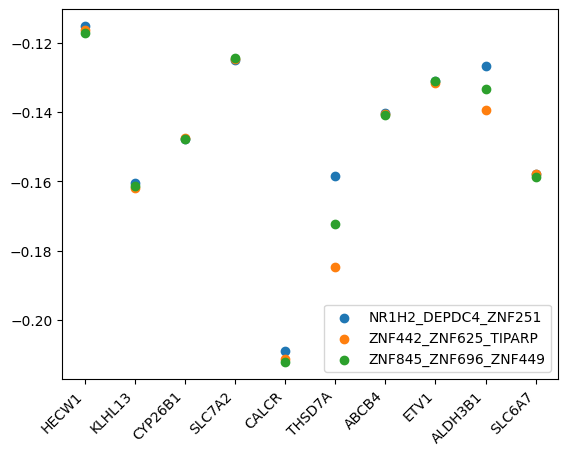

In [62]:
import matplotlib.pyplot as plt
plt.scatter(res_express.index[:10],res_express.iloc[:10, 0].values, label=res_express.columns[0])
plt.scatter(res_express.index[:10],res_express.iloc[:10,1].values, label=res_express.columns[1])
plt.scatter(res_express.index[:10],res_express.iloc[:10,2].values, label=res_express.columns[2])
plt.xticks(rotation=45,ha='right')
plt.legend()

#### Model gene expressions

In [37]:
#predict(best_model, [["SOX2", "KLF4", "MYC", "POU5F1"]])
# for p in perts_to_plot:
#         plot_perturbation(model, p, pool_size=100, save_file=f"{save_dir}/{p}.png")

In [35]:
#adata_t = adata_t[:, adata_t.var.highly_variable].copy()

In [36]:
# Generate a random single cell with the same genes for demonstration purposes
for lib in adata_t.obs.library.unique():
    print(f'Distance to {lib} =', abs((adata_t[adata_t.obs.library==lib].X - np.mean(single_cell, axis=0))).mean())
    print(f'Correlation with {lib} =', np.corrcoef(adata_t[adata_t.obs.library==lib].X.mean(axis=0), np.mean(single_cell, axis=0))[0,1])
# Apply the trained UMAP to the single cell
single_cell_umap = umap_model.transform(single_cell)

Distance to D0-fm = 0.21321268141513663
Correlation with D0-fm = 0.19841000919325158
Distance to D20-nr = 0.2284356846825983
Correlation with D20-nr = 0.2549451551560545
Distance to P20-nr = 0.2412217468891149
Correlation with P20-nr = 0.27692580208821915
Distance to D8-fm = 0.21715349418960217
Correlation with D8-fm = 0.2031927379490468


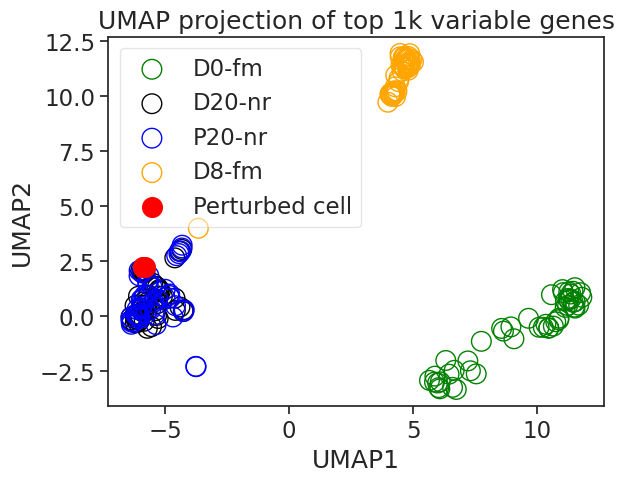

In [138]:
color = dict(zip(adata_combined.obs.library.unique().tolist(), ['green', 'black', 'blue','orange']))

for lib in adata_t.obs.library.unique():
    plt.scatter(adata_t.obsm['X_umap'][adata_t.obs.library == lib, 0][:50], 
                adata_t.obsm['X_umap'][adata_t.obs.library == lib, 1][:50], 
                edgecolors=color[lib], 
                label=lib, 
                alpha=0.99,
                s=200, 
                facecolors='none')    

#plt.scatter(adata.obsm['X_umap'][color!='black', 0], adata.obsm['X_umap'][color!='black', 1], c='blue', label='D20-NR', alpha=0.4)
plt.scatter(single_cell_umap[:, 0], single_cell_umap[:, 1], c='red', label='Perturbed cell',s=200)
plt.legend(facecolor='white', framealpha=0.5,)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP projection of top 1k variable genes')
plt.savefig('../umap_pert_2kgenes.pdf', bbox_inches='tight')
plt.show()

In [125]:
color

{'D0-fm': 'green', 'D20-nr': 'black', 'P20-nr': 'magenta', 'D8-fm': 'purple'}

In [399]:
test_loader = pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size,)['test_loader']
test_res = eval_perturb(test_loader, best_model, device)
# test_metrics, test_pert_res = compute_metrics(test_res)
test_metrics = compute_perturbation_metrics(
    test_res, pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"]
)
print(test_metrics)

Creating dataloaders....
Dataloaders created...


{'pearson': 0.3039771065210799, 'pearson_de': -0.8510659589799748, 'pearson_delta': 0.5505912948930985, 'pearson_de_delta': 0.9915649607133875}
